# Data

In [1]:
import copy
import random
from functools import wraps, partial

import torch
from torch import nn
import torch.nn.functional as F

from torchvision import transforms as T

# helper functions

def exists(val):
    return val is not None

def default(val, default):
    return val if exists(val) else default

def singleton(cache_key):
    def inner_fn(fn):
        @wraps(fn)
        def wrapper(self, *args, **kwargs):
            instance = getattr(self, cache_key)
            if instance is not None:
                return instance

            instance = fn(self, *args, **kwargs)
            setattr(self, cache_key, instance)
            return instance
        return wrapper
    return inner_fn

def get_module_device(module):
    return next(module.parameters()).device

def set_requires_grad(model, val):
    for p in model.parameters():
        p.requires_grad = val

# loss function # (algorithm 1 in the paper)

def loss_fn(
    teacher_logits,
    student_logits,
    teacher_temp,
    student_temp,
    centers,
    eps = 1e-20
):
    teacher_logits = teacher_logits.detach()
    student_probs = (student_logits / student_temp).softmax(dim = -1)
    teacher_probs = ((teacher_logits - centers) / teacher_temp).softmax(dim = -1)
    return - (teacher_probs * torch.log(student_probs + eps)).sum(dim = -1).mean()

# augmentation utils

class RandomApply(nn.Module):
    def __init__(self, fn, p):
        super().__init__()
        self.fn = fn
        self.p = p

    def forward(self, x):
        if random.random() > self.p:
            return x
        return self.fn(x)

# exponential moving average

class EMA():
    def __init__(self, beta):
        super().__init__()
        self.beta = beta

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

def update_moving_average(ema_updater, ma_model, current_model):
    for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
        old_weight, up_weight = ma_params.data, current_params.data
        ma_params.data = ema_updater.update_average(old_weight, up_weight)

# MLP class for projector and predictor

class L2Norm(nn.Module):
    def forward(self, x, eps = 1e-6):
        norm = x.norm(dim = 1, keepdim = True).clamp(min = eps)
        return x / norm

class MLP(nn.Module):
    def __init__(self, dim, dim_out, num_layers, hidden_size = 256):
        super().__init__()

        layers = []
        dims = (dim, *((hidden_size,) * (num_layers - 1)))

        for ind, (layer_dim_in, layer_dim_out) in enumerate(zip(dims[:-1], dims[1:])):
            is_last = ind == (len(dims) - 1)

            layers.extend([
                nn.Linear(layer_dim_in, layer_dim_out),
                nn.GELU() if not is_last else nn.Identity()
            ])

        self.net = nn.Sequential(
            *layers,
            L2Norm(),
            nn.Linear(hidden_size, dim_out)
        )

    def forward(self, x):
        return self.net(x)

# a wrapper class for the base neural network
# will manage the interception of the hidden layer output
# and pipe it into the projecter and predictor nets

class NetWrapper(nn.Module):
    def __init__(self, net, output_dim, projection_hidden_size, projection_num_layers, layer = -2):
        super().__init__()
        self.net = net
        self.layer = layer

        self.projector = None
        self.projection_hidden_size = projection_hidden_size
        self.projection_num_layers = projection_num_layers
        self.output_dim = output_dim

        self.hidden = {}
        self.hook_registered = False

    def _find_layer(self):
        if type(self.layer) == str:
            modules = dict([*self.net.named_modules()])
            return modules.get(self.layer, None)
        elif type(self.layer) == int:
            children = [*self.net.children()]
            return children[self.layer]
        return None

    def _hook(self, _, input, output):
        device = input[0].device
        self.hidden[device] = output.flatten(1)

    def _register_hook(self):
        layer = self._find_layer()
        assert layer is not None, f'hidden layer ({self.layer}) not found'
        handle = layer.register_forward_hook(self._hook)
        self.hook_registered = True

    @singleton('projector')
    def _get_projector(self, hidden):
        _, dim = hidden.shape
        projector = MLP(dim, self.output_dim, self.projection_num_layers, self.projection_hidden_size)
        return projector.to(hidden)

    def get_embedding(self, x):
        if self.layer == -1:
            return self.net(x)

        if not self.hook_registered:
            self._register_hook()

        self.hidden.clear()
        _ = self.net(x)
        hidden = self.hidden[x.device]
        self.hidden.clear()

        assert hidden is not None, f'hidden layer {self.layer} never emitted an output'
        return hidden

    def forward(self, x, return_projection = True):
        embed = self.get_embedding(x)
        if not return_projection:
            return embed

        projector = self._get_projector(embed)
        return projector(embed), embed

# main class

class Dino(nn.Module):
    def __init__(
        self,
        net,
        image_size,
        hidden_layer = -2,
        projection_hidden_size = 256,
        num_classes_K = 65336,
        projection_layers = 4,
        student_temp = 0.9,
        teacher_temp = 0.04,
        local_upper_crop_scale = 0.4,
        global_lower_crop_scale = 0.5,
        moving_average_decay = 0.9,
        center_moving_average_decay = 0.9,
        augment_fn = None,
        augment_fn2 = None
    ):
        super().__init__()
        self.net = net

        # default BYOL augmentation

        DEFAULT_AUG = torch.nn.Sequential(
            RandomApply(
                T.ColorJitter(0.8, 0.8, 0.8, 0.2),
                p = 0.3
            ),
            T.RandomGrayscale(p=0.2),
            T.RandomHorizontalFlip(),
            RandomApply(
                T.GaussianBlur((3, 3), (1.0, 2.0)),
                p = 0.2
            ),
            T.Normalize(
                mean=torch.tensor([0.485, 0.456, 0.406]),
                std=torch.tensor([0.229, 0.224, 0.225])),
        )

        self.augment1 = default(augment_fn, DEFAULT_AUG)
        self.augment2 = default(augment_fn2, DEFAULT_AUG)

        # local and global crops

        self.local_crop = T.RandomResizedCrop((image_size, image_size), scale = (0.05, local_upper_crop_scale))
        self.global_crop = T.RandomResizedCrop((image_size, image_size), scale = (global_lower_crop_scale, 1.))

        self.student_encoder = NetWrapper(net, num_classes_K, projection_hidden_size, projection_layers, layer = hidden_layer)

        self.teacher_encoder = None
        self.teacher_ema_updater = EMA(moving_average_decay)

        self.register_buffer('teacher_centers', torch.zeros(1, num_classes_K))
        self.register_buffer('last_teacher_centers',  torch.zeros(1, num_classes_K))

        self.teacher_centering_ema_updater = EMA(center_moving_average_decay)

        self.student_temp = student_temp
        self.teacher_temp = teacher_temp

        # get device of network and make wrapper same device
        device = get_module_device(net)
        self.to(device)

        # send a mock image tensor to instantiate singleton parameters
        self.forward(torch.randn(2, 3, image_size, image_size, device=device))

    @singleton('teacher_encoder')
    def _get_teacher_encoder(self):
        teacher_encoder = copy.deepcopy(self.student_encoder)
        set_requires_grad(teacher_encoder, False)
        return teacher_encoder

    def reset_moving_average(self):
        del self.teacher_encoder
        self.teacher_encoder = None

    def update_moving_average(self):
        assert self.teacher_encoder is not None, 'target encoder has not been created yet'
        update_moving_average(self.teacher_ema_updater, self.teacher_encoder, self.student_encoder)

        new_teacher_centers = self.teacher_centering_ema_updater.update_average(self.teacher_centers, self.last_teacher_centers)
        self.teacher_centers.copy_(new_teacher_centers)

    def forward(
        self,
        x,
        return_embedding = False,
        return_projection = True,
        student_temp = None,
        teacher_temp = None
    ):
        if return_embedding:
            return self.student_encoder(x, return_projection = return_projection)

        image_one, image_two = self.augment1(x), self.augment2(x)

        local_image_one, local_image_two   = self.local_crop(image_one),  self.local_crop(image_two)
        global_image_one, global_image_two = self.global_crop(image_one), self.global_crop(image_two)

        student_proj_one, _ = self.student_encoder(local_image_one)
        student_proj_two, _ = self.student_encoder(local_image_two)

        with torch.no_grad():
            teacher_encoder = self._get_teacher_encoder()
            teacher_proj_one, _ = teacher_encoder(global_image_one)
            teacher_proj_two, _ = teacher_encoder(global_image_two)

        loss_fn_ = partial(
            loss_fn,
            student_temp = default(student_temp, self.student_temp),
            teacher_temp = default(teacher_temp, self.teacher_temp),
            centers = self.teacher_centers
        )

        teacher_logits_avg = torch.cat((teacher_proj_one, teacher_proj_two)).mean(dim = 0)
        self.last_teacher_centers.copy_(teacher_logits_avg)

        loss = (loss_fn_(teacher_proj_one, student_proj_two) + loss_fn_(teacher_proj_two, student_proj_one)) / 2
        return loss


In [2]:
import segmentation_models_pytorch as smp
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
from glob import glob
from tqdm import tqdm
from torchvision import transforms
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import time
import sys
from operator import add
import random
%matplotlib inline

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.13 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


In [3]:
DEFAULT_RANDOM_SEED = 2021

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
# basic + torch 
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTorch(seed)
    print('seed set to:',seed)

In [4]:
seedEverything(DEFAULT_RANDOM_SEED)

seed set to: 2021


In [5]:
path = '/scratch/ps4364/ssl_med_seg/archive/Lung Segmentation/'
# image_path_test = '../input/chest-xray-masks-and-labels/Lung Segmentation/test/' 

In [6]:
images = os.listdir(path+'CXR_png/')
mask = os.listdir(path+'masks/')
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

check = [i for i in mask if "mask" in i]

In [7]:
testing_files = set(os.listdir(path+'CXR_png/')) & set(os.listdir(path+'masks/'))
training_files = check

In [8]:
class SegmentationDS(Dataset):
    """ create dataset by using image path and their labels """
    def __init__ (self, path, files, flag = "MONT", transform = (None, None)):
        self.path = path
        self.files = files
        self.flag = flag
        self.transform = transform

        
    def __len__(self):
        return len (self.files)

    def __getitem__(self, index):
        
        f = sorted(list(self.files))
        if self.flag == "MONT":    
            image = Image.open(os.path.join(self.path, "CXR_png", f[index])).convert('L')
            mask = Image.open(os.path.join(self.path, "masks", f[index])).convert('L')

        elif self.flag == "SHEN":
            image = Image.open(os.path.join(self.path, "CXR_png", f[index].split("_mask")[0] + ".png")).convert('L')
            mask = Image.open(os.path.join(self.path, "masks", f[index] + ".png")).convert('L')


        if self.transform != (None, None):
            image = self.transform[0](image)
            mask = self.transform[1](mask)
            
        return image, mask


In [9]:
mean0_1, std0_1 = [0.0, 0.0, 0.0], [1.0, 1.0, 1.0]

mean_imgnet, std_imgnet = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

mean1_1gray, std1_1gray = [0.5, ], [0.5, ]

dim = 256

In [10]:
image_tfms = transforms.Compose([
    transforms.Resize((dim, dim)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean1_1gray, 
                         std = std1_1gray)
])

mask_tfms = transforms.Compose([
    transforms.Resize((dim, dim)),
    transforms.ToTensor()
])

In [11]:
Mont_ds = SegmentationDS(path, testing_files, flag = "MONT", transform = (image_tfms, mask_tfms))
Shen_ds = SegmentationDS(path, training_files, flag = "SHEN", transform = (image_tfms, mask_tfms))

In [12]:
len(Mont_ds), len(Shen_ds)

(138, 566)

In [13]:
def imshow (img, mean_set, std_set):
    """ visualize torch tensor image """
    
    if img.shape[0] == 3:
        img = img.numpy ().transpose (1, 2, 0)
        mean = mean_set
        std = std_set
        img = img * std + mean
        img = np.clip (img, 0, 1)
        plt.figure (figsize = (5, 5))
        plt.imshow (img)
        
    elif img.shape[0] == 1:
        img = img.numpy ().transpose (1, 2, 0)
        mean = mean_set
        std = std_set
        img = img * std + mean
        img = np.clip (img, 0, 1)
    
        plt.figure (figsize = (5, 5))
        plt.imshow (img,cmap='gray')

torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
tensor(-1.) tensor(1.)
tensor(0.) tensor(1.)


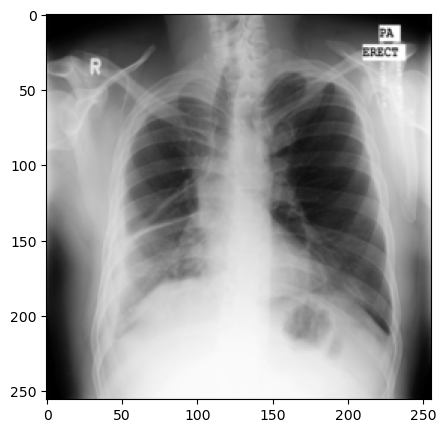

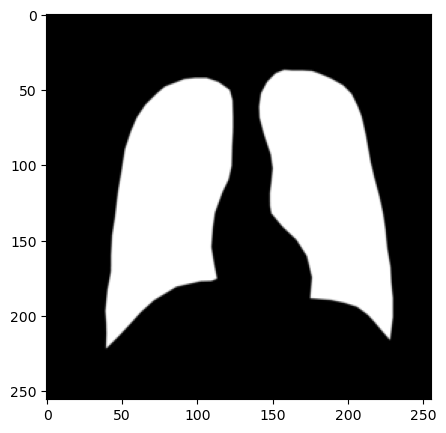

In [14]:
idx = np.random.choice (len (Mont_ds))
img, lbl = Mont_ds [idx]
print (img.shape)
print (lbl.shape)
print(img.min(), img.max())
print(lbl.min(), lbl.max())
imshow(img, mean1_1gray, std1_1gray)
imshow(lbl, mean1_1gray, std1_1gray)

In [15]:
train_ds = torch.utils.data.ConcatDataset([Shen_ds])

len(train_ds)

566

In [16]:
train_size = int(0.80 * len(train_ds))
valid_size = len(train_ds) - train_size
train_ds, valid_ds = torch.utils.data.random_split(train_ds, [train_size, valid_size])

print(len(train_ds), len(valid_ds))

452 114


In [17]:
train_dl = DataLoader (train_ds, batch_size = 8, shuffle = True)
valid_dl = DataLoader (valid_ds, batch_size = 8, shuffle = True)

# Loss Function

In [18]:
import torch.nn as nn
import torch.nn.functional as F

In [19]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

# Metrics

In [20]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

In [21]:
def calculate_metrics(y_pred, y_true):
    """ Ground truth """
    y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    """ Prediction """
    y_pred = y_pred.cpu().detach().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)
#     score_f1 = f1_score(y_true, y_pred)
#     score_recall = recall_score(y_true, y_pred)
#     score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)

    return [score_jaccard, score_acc]

# Model

In [22]:
for x,y in train_dl:
    break

In [23]:
x.shape

torch.Size([8, 1, 256, 256])

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [25]:
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)


#Unet_Builder(input_channel=1, output_channel=1)
# model.eval()

In [26]:
def save_checkpoint (state, filename):
    """ saving model's weights """
    print ('=> saving checkpoint')
    torch.save (state, filename)


In [27]:
def train(model, loader, optimizer, loss_fn, metric_fn, device):
    epoch_loss = 0.0
    metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
    steps = len(loader)
    model.train()
    for i, (x, y) in enumerate (loader):
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x.repeat(1,3,1,1))
        loss = loss_fn(y_pred, y)
        loss.backward()
        
        score = metric_fn(y_pred, y)
        metrics_score = list(map(add, metrics_score, score))
        
        optimizer.step()
        epoch_loss += loss.item()
        
        sys.stdout.flush()
        sys.stdout.write('\r Step: [%2d/%2d], loss: %.4f - acc: %.4f' % (i, steps, loss.item(), score[1]))
    sys.stdout.write('\r')

    epoch_loss = epoch_loss/len(loader)
    
    epoch_jaccard = metrics_score[0]/len(loader)
#     epoch_f1 = metrics_score[1]/len(loader)
    epoch_acc = metrics_score[1]/len(loader)
    
    return epoch_loss, epoch_jaccard, epoch_acc

In [28]:
def evaluate(model, loader, loss_fn, metric_fn, device):
    epoch_loss = 0.0
    metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x.repeat(1,3,1,1))
            loss = loss_fn(y_pred, y)
            
            score = metric_fn(y_pred, y)
            metrics_score = list(map(add, metrics_score, score))
            
            epoch_loss += loss.item()

        epoch_loss = epoch_loss / len(loader)
        
        epoch_jaccard = metrics_score[0] / len(loader)
#         epoch_f1 = metrics_score[1] / len(loader)
        epoch_acc = metrics_score[1] / len(loader)
    
    return epoch_loss, epoch_jaccard, epoch_acc

In [29]:
checkpoint_path = 'unet_r34.pth'
epochs = 10
batch_size = 8
lr = 1e-4

In [30]:
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()
# metric_fn = calculate_metrics()

""" Training the model """
best_valid_loss = float("inf")

/ext3/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [31]:
torch.cuda.empty_cache()

In [32]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [33]:
def fit (model, train_dl, valid_dl, optimizer, epochs, loss_fn, metric_fn, checkpoint_path):
    """ fiting model to dataloaders, saving best weights and showing results """
    losses, val_losses, accs, val_accs = [], [], [], []
    jaccards, val_jaccards = [], []
    best_val_loss = float("inf")
    
    since = time.time()
    for epoch in range (epochs):
        ts = time.time()
        
        loss, jaccard, acc = train(model, train_dl, optimizer, loss_fn, metric_fn, device)
        val_loss, val_jaccard, val_acc = evaluate(model, valid_dl, loss_fn, metric_fn, device)

        
        losses.append(loss)
        accs.append(acc)
        jaccards.append(jaccard)
        
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_jaccards.append(val_jaccard)
        
        te = time.time()
        
        if val_loss < best_val_loss:
            data_str = f"===> Valid loss improved from {best_val_loss:2.4f} to {val_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
            print(data_str)
            best_val_loss = val_loss
            torch.save(model.state_dict(), checkpoint_path)

        epoch_mins, epoch_secs = epoch_time(ts, te)
        
        print ('Epoch [{}/{}], loss: {:.4f} - jaccard: {:.4f} - acc: {:.4f} - val_loss: {:.4f} - val_jaccard: {:.4f} - val_acc: {:.4f}'.format (epoch + 1, epochs, loss, jaccard, acc, val_loss, val_jaccard, val_acc))
        print(f'Time: {epoch_mins}m {epoch_secs}s')
        
    period = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(period // 60, period % 60))

    return dict(loss = losses, val_loss = val_losses, acc = accs, val_acc = val_accs, jaccard = jaccards, val_jaccard = val_jaccards)


In [34]:
res = fit(model, train_dl, valid_dl, optimizer, epochs, loss_fn, calculate_metrics, checkpoint_path)

===> Valid loss improved from inf to 0.5008. Saving checkpoint: unet_r34.pth
Epoch [1/10], loss: 0.7460 - jaccard: 0.7545 - acc: 0.9210 - val_loss: 0.5008 - val_jaccard: 0.8824 - val_acc: 0.9670
Time: 2m 13s
===> Valid loss improved from 0.5008 to 0.3461. Saving checkpoint: unet_r34.pth
Epoch [2/10], loss: 0.4032 - jaccard: 0.9065 - acc: 0.9753 - val_loss: 0.3461 - val_jaccard: 0.9171 - val_acc: 0.9780
Time: 1m 40s
===> Valid loss improved from 0.3461 to 0.2796. Saving checkpoint: unet_r34.pth
Epoch [3/10], loss: 0.3072 - jaccard: 0.9208 - acc: 0.9793 - val_loss: 0.2796 - val_jaccard: 0.9200 - val_acc: 0.9790
Time: 1m 25s
===> Valid loss improved from 0.2796 to 0.2417. Saving checkpoint: unet_r34.pth
Epoch [4/10], loss: 0.2488 - jaccard: 0.9287 - acc: 0.9814 - val_loss: 0.2417 - val_jaccard: 0.9225 - val_acc: 0.9797
Time: 1m 25s
===> Valid loss improved from 0.2417 to 0.2146. Saving checkpoint: unet_r34.pth
Epoch [5/10], loss: 0.2160 - jaccard: 0.9283 - acc: 0.9812 - val_loss: 0.2146 -

In [35]:
def plot_acc_loss (loss, val_loss, acc, val_acc):
    """ plot training and validation loss and accuracy """
    plt.figure (figsize = (12, 4))
    plt.subplot (1, 2, 1)
    plt.plot (range (len (loss)), loss, 'b-', label = 'Training')
    plt.plot (range (len (loss)), val_loss, 'bo-', label = 'Validation')
    plt.xlabel ('Epochs')
    plt.ylabel ('Loss')
    plt.title ('Loss')
    plt.legend ()

    plt.subplot (1, 2, 2)
    plt.plot (range (len (acc)), acc, 'b-', label = 'Training')
    plt.plot (range (len (acc)), val_acc, 'bo-', label = 'Validation')
    plt.xlabel ('Epochs')
    plt.ylabel ('accuracy')
    plt.title ('Accuracy')
    plt.legend ()

    plt.show ()

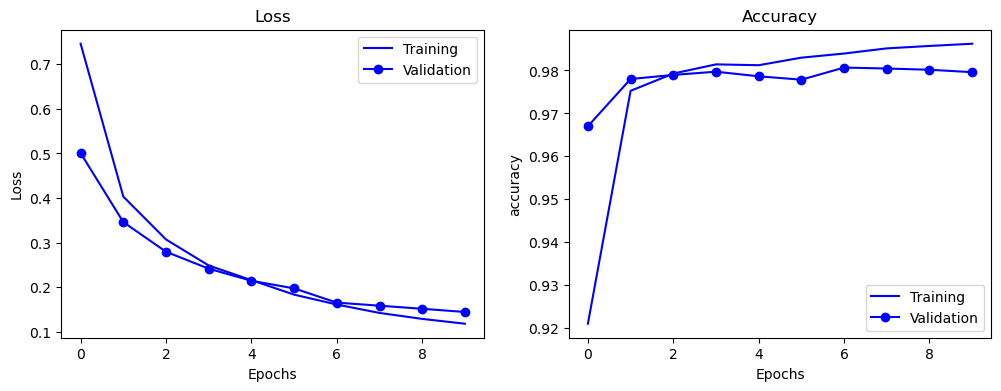

In [36]:
loss, val_loss = res['loss'], res['val_loss']
acc, val_acc = res['acc'], res['val_acc']
plot_acc_loss (loss, val_loss, acc, val_acc)

# test

In [37]:
test_dl = DataLoader(Mont_ds, batch_size = 8, shuffle = True)

In [38]:
checkpoint_path

'unet_r34.pth'

In [39]:
model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

In [40]:
model = model.to(device)

In [41]:
_, jcc, acc = evaluate(model, test_dl, loss_fn, calculate_metrics, device)

In [42]:
jcc

0.8981154295223058

In [43]:
acc

0.9733574125501845